### import

In [1]:
import pandas as pd 
import numpy as np
import math
import re

from icecream import ic
from tqdm.notebook import tqdm 

from utils.custom_utils import load_var, save_var
from utils.webscraping import ArticleScraper
from utils.search_address import CheckAddressLevels
import utils.search_address as sa

from importlib import reload

df_addr = pd.read_parquet('./address/df_addr.parquet.gzip')
df_text = pd.read_parquet('./dataframe/flasher_hk_20130101_20220307_loc.parquet.gzip')


In [2]:
# Loading required libraries
import os

from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain.docstore.document import Document
from langchain.document_loaders import PyPDFLoader, DirectoryLoader, TextLoader
from langchain.document_loaders import UnstructuredHTMLLoader, BSHTMLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.chains import RetrievalQA
from langchain.memory import ConversationSummaryMemory

from langchain.llms import Ollama
# from langchain_openai import OpenAIEmbeddings
# from langchain.embeddings import GPT4AllEmbeddings
from langchain.embeddings import OllamaEmbeddings  
from langchain.prompts import PromptTemplate

In [3]:
DATA_PATH="data/"
DB_PATH = "vectorstores/db/"

In [4]:
template = """<s>[INST] Given the context - {context} </s>[INST] [INST] Answer the following question - {question}[/INST]"""
pt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

In [69]:
# ver.1
ret_prompt = """
{"who": "", "when": "", "where": "", "what": "", "other_regional_info": ",,,,,,"}

who, when, where and what is it happened in the article? 
answer them as json format as 'who, when, where and what'.
give me 'all' regional information about physical places like administrative district name, building, regional branch and others.
answer them into 'other_regional_info'.
"""

In [92]:
# ver.1.2
ret_prompt = """
{"who": "", "when": "", "where": "", "what": "", "other_regional_info": ",,,,,,"}

who, when, where and what is it happened in the article? 
answer them as json format as 'who, when, where and what'.
give me 'all' regional information about physical places like administrative district name, building, regional branch and others.
put the all regional information into 'other_regional_info' separating with comma.
"""

In [40]:
# ver.2
ret_prompt = """
who, when, where and what is it happened in the article? 
and give me all the possible regional information related to administrative district names, regional branch, buildings and so on.
"""

In [46]:
# ver.3
ret_prompt = """
where is it happened in the article? 
give me 'all' related regional information about physical places like administrative district name, building, regional branch and others.
"""

In [42]:
# ver.4
ret_prompt = """
사건 장소는 어디인가?
장소와 관련된 모든 정보를 열거하라.
"""

In [43]:
# ver.5
ret_prompt = """
- info 1
- info 2
- ...

where is it happened in the article? 
give me 'all' related regional information about physical places like administrative district name, building, regional branch and others.
make the bullet points for the information.
"""

In [60]:
# ver.6
ret_prompt = """
- who:
- when:
- where:
- what:
- other related regional information:

who, when, where and what is it happened in the article? 
give me 'all' regional information about physical places like administrative district name, building, regional branch and others.
"""

In [60]:
# ver.7
ret_prompt = """
- who
  -
- when
  - 
- where
  - 
- what
  -
- other related regional information
  - 

who, when, where and what is it happened in the article? 
give me 'all' regional information about physical places like administrative district name, building, regional branch and others.
"""

### process

#### get_json

In [32]:
# loader = TextLoader("./hk_test.md")
# documents = loader.load()

In [50]:
vectorstore.delete_collection()

In [130]:
import json 

def get_json(json_text: str, verbose: bool = False) -> dict:
    """Parse JSON text into a Python dictionary.
    
    Args:
        json_text (str): JSON text to parse.
        verbose (bool, optional): If True, print JSON text. Defaults to False.
    
    Returns:
        dict: Parsed JSON data as a dictionary, or None if parsing fails.
    """
    if verbose:
        print("Input JSON text:")
        print(json_text)

    try:
        json_data = json.loads(json_text)
    except json.JSONDecodeError as e:
        print("Error loading JSON:", e)
        return None
    except Exception as e:
        print("An unknown error occurred:", e)
        return None

    return json_data


In [109]:
def retrieve_info(
    text: str,
    pt: PromptTemplate,
    ret_prompt: str,
    model='gemma:2b'):
    doc =  Document(page_content=text, metadata={"source": "local"})
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, chunk_overlap=50)
    texts=text_splitter.split_documents([doc])

    ic(type(texts))
    ic(len(texts))
    
    vectorstore = Chroma.from_documents(
        documents=texts,
        embedding=OllamaEmbeddings(
            model=model
        ),
    )
    
    rag = RetrievalQA.from_chain_type(
        llm=Ollama(model=model),
        retriever=vectorstore.as_retriever(),
        memory=ConversationSummaryMemory(llm=Ollama(model=model)),
        chain_type_kwargs={"prompt": pt, "verbose": False},
    )
    
    result = rag.invoke(ret_prompt)
    vectorstore.delete_collection()
    
    return result

In [7]:
index = 3
text_iter = iter(zip(df_text.index[index:], df_text.loc[index:, 'content']))

In [84]:
index_iter, text = next(text_iter)
text = sa.clean_text(text)
print(index_iter)

9


In [85]:
text

'사진=KBS 캡처\n제주에서 한 여고생이 학교 폭력을 신고했다가 가해 학생들로부터 보복 폭행을 당하는 사건이 발생했다. 지난 8일 KBS 보도에 따르면 피해 여고생 A 양은 지난달 31일 오후 5시께 제주 시청 인근 주차장에서 한 남학생이 또래로 보이는 청소년 2명으로부터 폭행당하는 모습을 목격하고 학교와 경찰에 알렸다. A 양이 신고했다는 사실을 알게 된 가해 청소년들은 이날 밤 A 양을 불러내 보복 폭행했다. 당시 폭행 현장에는 가해 청소년 2명뿐만 아니라 다른 학교 학생 6명도 함께 있었던 것으로 알려졌다.두 차례 폭행을 당한 A 양의 오른쪽 뺨은 살갗이 벗겨져 붉게 부어올랐다. 다리와 팔에도 피멍이 들었으며, 심리적 충격까지 심각한 것으로 전해졌다.A 양의 부모는 가해 청소년으로부터 협박 전화까지 받았다고 주장했다. A 양의 부모는 "본인들만 고소하고 옆에서 도와준 친구들은 건들지 말라고 협박조로 얘기했다"며 "그 전화 받고 한숨도 못 잤다. 우리 애가 밤사이 새벽까지 끌려다니면서 맞았다고 생각하니 가슴이 무너질 것 같다"고 호소했다.제주동부경찰서는 가해 청소년 2명을 특수폭행 혐의로 입건했고, 학교 측은 자세한 경위를 조사하고 있다.홍민성 한경닷컴 기자 mshong@hankyung.com'

In [93]:
result = retrieve_info(text=text, pt=pt, ret_prompt=ret_prompt, model='gemma:2b')
# result = retrieve_info(text=text, pt=pt, ret_prompt=ret_prompt, model='phi3')

Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1


In [94]:
# ver.1
print(result['result'])

{
  "who": "A 양",
  "when": "지난 8일",
  "where": "제주 시청 인근 주차장",
  "what": "한 남학생이 또래로 보이는 청소년 2명으로부터 폭행당하는 모습을 목격하고 학교와 경찰에 알렸다",
  "other_regional_info": ", 제주동부경찰서, 학교 측"
}


#### results: gemma 2b

In [57]:
# ver.6
print(result['result'])

**who:** A씨, B씨, C씨, D양

**when:** 19일

**where:** 포항지방법원 포항지원 제1형사부(권순향 재판장)

**what:** A씨 등 3명이 공범 몰래 여고생을 성폭행하고 70%를 갈취한 혐의로 기소된 혐의로 징역 6년, 5년, 4년 선고

**other related regional information:**
- A씨는 고향 후배인 D양(17)에게 숙식을 제공하면서 성매매를 강요한 혐의를 받았다.
- D양이 성매매 대가로 받아돈 금액 중 70%를 갈취했다.
- 연인 관계인 A씨와 C씨는 2020년 8월 D양이 경기 인천으로 도망치자 "전화를 받지 않으면 아버지에게 이야기하겠다"고 협박했고, 협박에 돌아온 D양을 포항시 북구 한 모텔에 한 달 동안 감금한 혐의도 받고 있다.


In [62]:
# ver.7
print(result['result'])

**who:** A씨, B씨, C씨, D양 

**when:** 19일

**where:**  포항지방법원 포항지원 제1형사부(권순향 재판장)

**what:** A씨 등 3명이 공범 몰래 여고생을 성폭행한 혐의로 기소된 징역 6년, 징역 5년, 징역 4년을 선고했다.

**other related regional information:**

- 연인 관계인 A씨와 C씨는 2020년 8월 D양이 경기 인천으로 도망치자 "전화를 받지 않으면 아버지에게 이야기하겠다"고 협박했고, 협박에 돌아온 D양을 포항시 북구 한 모텔에 한 달 동안 감금한 혐의도 받았다. 
- 이들은 당시 D양이 도망치지 못하도록 휴대폰에 위치추적 앱까지 설치해 관리했고, A씨는 연인인 C씨 몰래 D양을 4회에 걸쳐 성폭행한 혐의도 받는다.


#### results: phi3

ver.1

In [30]:
result

{'query': '\n{"who": "", "when": "", "where": "", "what": "", "other_regional_info": [\'\',\'\',\'\',,,]}\n\n\x08who, when, where and what is it happened in the article? \nanswer them as json format as \'who, when, where and what\'.\ngive me \'all\' regional information about physical places like administrative district name, building, regional branch and others.\nanswer them into \'other_regional_info\'.\n',
 'history': '',
 'result': '{\n  "who": "A씨, B씨, C씨, D양",\n  "when": "19일, 2020년 8월, 2 Habco building",\n  "where": "경기 인천으로, 북구 한 모텔, 여고생에게 제공된 현재 위치",\n  "what": "근무하는 일말 부도인 A씨, B씨, C씨의 성매매 강조와 투자에 대한 면역과 D양의 성폭행을 사타.",\n  "other_regional_info": [\n    "경기도",\n    "인천광역시 북구",\n    "여고생에서 제공된 현재 위치"\n  ]\n}'}

ver.3

In [34]:
result

{'query': "\nwhere is it happened in the article? \ngive me 'all' related regional information about physical places like administrative district name, building, regional branch and others.\n",
 'history': '',
 'result': "The events described in the provided text occur at several locations within South Korea:\n\n1. **Daegu Gangnam District Office** - The Daegu Gangnam District Office is mentioned where D's family was reportedly taken after his disappearance, and an investigation by investigators led to physical confrontations involving A, B, and C individuals.\n\n2. **Korea High Court Seoul Branch** - This is the location of a hearing that took place on October 19, where the Daegu District Prosecutors' Office made judgments against A, B, and C for their involvement in D' Marketplace Mall Gang assault case.\n\n3. **Daegu Police Station North Seoul Branch** - The police station is implicated as it was involved when investigators arrested A after a confrontation between him and his relati

The events described in the provided text occur at several locations within South Korea:\n\n1. 

**Daegu Gangnam District Office** - The Daegu Gangnam District Office is mentioned where D's family was reportedly taken after his disappearance, and an investigation by investigators led to physical confrontations involving A, B, and C individuals.\n\n2. 

**Korea High Court Seoul Branch** - This is the location of a hearing that took place on October 19, where the Daegu District Prosecutors' Office made judgments against A, B, and C for their involvement in D' Marketplace Mall Gang assault case.\n\n3. 

**Daegu Police Station North Seoul Branch** - The police station is implicated as it was involved when investigators arrested A after a confrontation between him and his relative at the Daegu Gangnam District Office on October 18, following a report that D had run away to Tokyo.\n\n4. 

**Daegu Gangnam Police Station (Korea High Court Seoul Branch)** - This police station is involved in the arrest of A when he was apprehended by investigators at the Daegu Gangnam District Office on October 18.\n\n5. 

**Jangsu-dong, Yeonhui-dong, Haeundae District, Busan, South Korea** - D ran away to this location in Tokyo after being reported missing from his home in Daegu, as mentioned by a relative of B and C during the court hearing on October 19.\n\n6. 

**Gyeongsangbuk-do (South Gyeongsang Province)** - This is the administrative region where D's family resides, located near Busan city.\n\n7. 

**Busan Metropolitan City (Yeonhui-dong and Haeundae District)**: These are districts within Busan that were mentioned in relation to D's disappearance after he reportedly ran away there from his home district.\n\n8. 

**Tokyo, Japan** - This is the city where D allegedly went after disappearing from Daegu; however, it was not confirmed if D stayed or left Tokyo for a long duration as per the report during the court hearing on October 19.\n\nThese locations are directly related to the incidents and legal proceedings described in the article regarding D's disappearance and subsequent events involving A, B, and C individuals.

In [44]:
print(
    "- Information regarding a university student providing accommodation during detention and instructing on marriage registration:\n\n  - Incident took place in Dankook University\n\n  - No specific administrative district or building mentioned directly, but implied to be within South Korea (the country where Dankook University is located)\n\n- Detained individuals were directed to provide shelter for a young man during his escape from custody:\n Administered by the Daegu District Court in Daegu\n\n  - No specific building or regional branch mentioned directly, but implied to be within South Korea (the country where Dankook University and Daegu are located)\n\n- A woman was detained for planning her boyfriend's kidnapping:\n\n  - Incident took place in Gyeongsangbuk-do province, which includes the city of Andong, given that it is related to Dankook University students who were involved. However, specific administrative district and building names are not directly mentioned.\n\n- A young man was arrested for attempting kidnap:\n\n  - Incident likely occurred in Gyeongsangbuk-do province due to the connection with Dankook University students. Specific location within the province is not detailed.\n\n- The woman's boyfriend managed to escape and fled Daegu, seeking refuge at a family member's house:\n\n  - Escape took place in Daegu city, South Korea.\n\n- A man was caught trying to kidnap his girlfriend after her release from prison:\n\n  - Incident likely occurred in Gyeongsangbuk-do province due to the connection with Dankook University students. Specific location within the province is not detailed.\n\n- The man who tried to escape custody faced legal consequences for resisting arrest and kidnapping charges:\n\n  - Case handled by Daegu District Court, South Korea.\n\n- An individual assaulted a police officer in an attempt to detain another suspect during his escape:\n\n  - Incident occurred in Andong city, Gyeongsangbuk-do province, within the broader context of Dankook University student involvement but not specified at the administrative district or building level.\n\n- A university student was arrested for attempting to abduct a female relative and subsequently resisting arrest:\n\n  - Incident likely occurred in Gyeongsangbuk-do province due to its connection with Dankook University students. Specific location within the province is not detailed."
)

- Information regarding a university student providing accommodation during detention and instructing on marriage registration:

  - Incident took place in Dankook University

  - No specific administrative district or building mentioned directly, but implied to be within South Korea (the country where Dankook University is located)

- Detained individuals were directed to provide shelter for a young man during his escape from custody:
 Administered by the Daegu District Court in Daegu

  - No specific building or regional branch mentioned directly, but implied to be within South Korea (the country where Dankook University and Daegu are located)

- A woman was detained for planning her boyfriend's kidnapping:

  - Incident took place in Gyeongsangbuk-do province, which includes the city of Andong, given that it is related to Dankook University students who were involved. However, specific administrative district and building names are not directly mentioned.

- A young man was arrested

#### tqdm

In [95]:
total_length = len(df_text)
total_length

377

In [ ]:
df_text["rag_1"] = ''

In [112]:
for index, row in tqdm(df_text[136:].iterrows(), total=total_length):
    text = row['content']
    if isinstance(text, str) and len(text) > 0:
        result = retrieve_info(text=row['content'], pt=pt, ret_prompt=ret_prompt)
        df_text.loc[index, "rag_1"] = result['result']

  0%|          | 0/377 [00:00<?, ?it/s]

ic| type(texts): <class 'list'>
ic| len(texts): 1
Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1
ic| type(texts): <class 'list'>
ic| len(texts): 1
Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1
ic| type(texts): <class 'list'>
ic| len(texts): 4
ic| type(texts): <class 'list'>
ic| len(texts): 1
Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1
ic| type(texts): <class 'list'>
ic| len(texts): 1
Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1
ic| type(texts): <class 'list'>
ic| len(texts): 1
Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1
ic| type(texts): <class 'list'>
ic| len(texts): 1
Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1
ic| type(texts): <class 'list'>
ic| len(texts): 1


In [106]:
index = 135
text = df_text.iloc[index]['content']
result = retrieve_info(text=text, pt=pt, ret_prompt=ret_prompt)
df_text.loc[index, "rag_1"] = result['result']

In [116]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   범죄 유형            0 non-null      float64
 1   지역               334 non-null    object 
 2   위도               103 non-null    float64
 3   경도               103 non-null    float64
 4   중복 여부            0 non-null      float64
 5   퀄리티              0 non-null      float64
 6   제외 여부            0 non-null      float64
 7   기사제목             377 non-null    object 
 8   사건 장소            328 non-null    object 
 9   수사 기관            377 non-null    object 
 10  본문               377 non-null    object 
 11  URL              209 non-null    object 
 12  일자               377 non-null    int64  
 13  언론사              377 non-null    object 
 14  기고자              286 non-null    object 
 15  비고               0 non-null      float64
 16  selenium_html    209 non-null    object 
 17  content         

In [114]:
df_text['rag_1_len'] = 0

In [115]:
df_text['rag_1_len'] = [len(row['rag_1']) for index, row in df_text.iterrows()]

<Axes: >

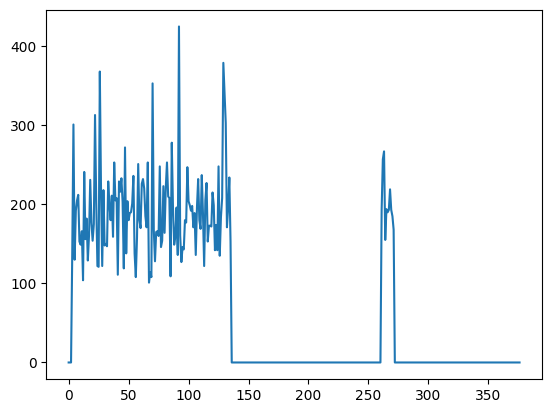

In [118]:
df_text['rag_1_len'].plot()

#### save to parquet

In [119]:
df_text.to_parquet('./dataframe/flasher_hk_20130101_20220307_rag.parquet.gzip', compression='gzip')

In [120]:
df_text.to_excel('./dataframe/flasher_hk_20130101_20220307_rag.xlsx', index=False)

#### save df_hk_json

In [81]:
save_var(df, "df_hk_json")

In [3]:
df_hk_json = load_var("df_hk_json")

#### inspection

In [133]:
df_hk_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   범죄 유형   0 non-null      float64
 1   지역      3 non-null      object 
 2   위도      0 non-null      float64
 3   경도      0 non-null      float64
 4   중복 여부   6 non-null      object 
 5   퀄리티     0 non-null      float64
 6   제외 여부   0 non-null      float64
 7   기사제목    27 non-null     object 
 8   사건 장소   27 non-null     object 
 9   수사 기관   27 non-null     object 
 10  본문      27 non-null     object 
 11  URL     27 non-null     object 
 12  일자      27 non-null     int64  
 13  언론사     27 non-null     object 
 14  기고자     27 non-null     object 
 15  비고      0 non-null      float64
 16  text    27 non-null     object 
 17  who     5 non-null      object 
 18  when    5 non-null      object 
 19  where   5 non-null      object 
 20  what    5 non-null      object 
 21  json    27 non-null     object 
dtypes: f

In [7]:
df_hk_json.head(1)

,범죄 유형,지역,위도,경도,중복 여부,퀄리티,제외 여부,기사제목,사건 장소,수사 기관,...,일자,언론사,기고자,비고,text,who,when,where,what,json
0,NaN,NaN,NaN,NaN,19번과 중복,NaN,NaN,"부산 돌려차기 男 ""나가면 죽인다"" 구치소 동료 충격 제보","부산,상해","SBS,경찰,부산",...,20230410,한국경제,김세린,NaN,사건 당시 폐쇄회로(CC)TV에 담긴 폭행 영상. /사진= SBS '그것이 알고싶다...,B씨,2023년 10월 10일,부산의 한 모텔,"성폭행 혐의로 1심에서 12년형을 선고받고 복역 중이며, 형량이 과도하다는 취지로 ...","{\n""who"": ""B씨"",\n""when"": ""7분 동안 성폭행이 일어났다"",\n""..."


In [8]:
df_hk_json.iloc[2]['json']

'{"who": "남성", "when": "3월 서울 관악구 골목길에서 난동을 부렸던 날", "where": "서울", "what": "남성이 여성을 향해 달려갔다, 갑자기 돌진하는 남성을 보며 놀란 여성이 횡단보도로 뛰어가며 도망쳤지만, 남성은 그 뒤를 쫓아갔다."'

#### search address in text

In [4]:
df_where = df_hk_json['where']

In [8]:
df_where.head()

0           부산의 한 모텔
1         김제시의 한 아파트
2    서울 강남구 압구정동의 길가
3         김제시의 한 아파트
4         김제시의 한 아파트
Name: where, dtype: object

In [5]:
df_addr = pd.read_csv('./address/address.csv')

#### retrieve

In [6]:
history = []
for item in df_where[:3]:
    if isinstance(item, str):
        ic(item)
        ra = RetrieveAddress(df_addr)
        res = ra.process(item)
        history.append(ra)
        ic(res)

ic| item: '부산의 한 모텔'
ic| res: ''
ic| item: '김제시의 한 아파트'
ic| res: '전북특별자치도 김제시'
ic| item: '서울 강남구 압구정동의 길가'
ic| res: '서울특별시 강남구 압구정동'


In [18]:
history[0].df_filtered

,lv1,lv2,lv3,lv4,lv5


'부산'은 첫번째 컬럼이므로 필터링이 되지 않기 때문에,  
아무 데이터도 없다.

In [19]:
history[1].df_filtered

,lv1,lv2,lv3,lv4,lv5
9538,전북특별자치도,김제시,요촌동,NaN,NaN
9539,전북특별자치도,김제시,신풍동,NaN,NaN
9540,전북특별자치도,김제시,용동,NaN,NaN
9541,전북특별자치도,김제시,검산동,NaN,NaN
9542,전북특별자치도,김제시,순동,NaN,NaN
...,...,...,...,...,...
9751,전북특별자치도,김제시,금산면,용산리,NaN
9752,전북특별자치도,김제시,금산면,구월리,NaN
9753,전북특별자치도,김제시,광활면,옥포리,NaN
9754,전북특별자치도,김제시,광활면,은파리,NaN


In [20]:
history[1].df_count

,index,lv1,lv2,lv3
0,9538,218,218,218
1,9539,218,218,218
2,9540,218,218,218
3,9541,218,218,218
4,9542,218,218,218
...,...,...,...,...
213,9751,218,218,218
214,9752,218,218,218
215,9753,218,218,218
216,9754,218,218,218


In [7]:
history[1].level

2

#### retrieving where

In [112]:
json_columns = ['who', 'when', 'where', 'what']

In [110]:
json_columns_2 = ['who_2', 'when_2', 'where_2', 'what_2']

In [113]:
for index in tqdm(range(df_len)):
    result = get_json(df.iloc[index]['json_2'])
    if result != None:
        for column in json_columns:
            df.loc[index, f"{column}_2"] = result[column]

  0%|                                                                                                                                                                                    | 0/27 [00:00<?, ?it/s]/var/folders/r0/w084nh2s0v3fstg3n70027500000gn/T/ipykernel_43935/1434628716.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '60대 남성' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, f"{column}_2"] = result[column]
/var/folders/r0/w084nh2s0v3fstg3n70027500000gn/T/ipykernel_43935/1434628716.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '오후 2시' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, f"{column}_2"] = result[column]
/var/folders/r0/w084nh2s0v3fstg3n70027500000gn/T/ipykernel_43935/1434628716.py:5: FutureWarning: Settin

Error loading JSON: Expecting ',' delimiter: line 5 column 83 (char 247)
Error loading JSON: Expecting ',' delimiter: line 1 column 136 (char 135)
Error loading JSON: Expecting ',' delimiter: line 5 column 40 (char 134)
Error loading JSON: Expecting ',' delimiter: line 5 column 90 (char 147)
Error loading JSON: Expecting ',' delimiter: line 1 column 189 (char 188)
Error loading JSON: Expecting ',' delimiter: line 1 column 167 (char 166)
Error loading JSON: Expecting ',' delimiter: line 1 column 147 (char 146)
Error loading JSON: Expecting ',' delimiter: line 1 column 200 (char 199)
Error loading JSON: Expecting ',' delimiter: line 1 column 133 (char 132)


In [117]:
df[['where','where_2']]

,where,where_2
0,한 모텔에서 검거됐다,NaN
1,김제시의 한 아파트,김제시 한 아파트
2,서울 강남구 압구정동의 길가,서울 관악구 골목길
3,서울 강남구 압구정동의 길가,서울 강남구 압구정동
4,김제시의 한 아파트,서울 강남구 압구정동의 길가
5,NaN,강남역 인근 거리
6,강남 압구정동의 길가,NaN
7,경기 군포시 한 아파트 입구,NaN
8,사진=게티이미지뱅크,아파트 단지 내에서
9,부산,NaN


### City Short Name

### read excel

In [92]:
df_addr = pd.read_excel("./address/법정동_20240201.xlsx")

In [120]:
df_addr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20565 entries, 0 to 20564
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   법정동코드   20565 non-null  int64  
 1   시도명     20565 non-null  object 
 2   시군구명    20395 non-null  object 
 3   읍면동명    20278 non-null  object 
 4   동리명     15212 non-null  object 
 5   생성일자    20565 non-null  int64  
 6   말소일자    0 non-null      float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ MB


In [121]:
df_addr.head(3)

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
0,1100000000,서울특별시,NaN,NaN,NaN,19880423,NaN
1,1111000000,서울특별시,종로구,NaN,NaN,19880423,NaN
2,1111010100,서울특별시,종로구,청운동,NaN,19880423,NaN


### Province

In [173]:
df_prov = df_addr[df_addr["시군구명"].isna() == True]

In [174]:
prov_index = df_prov.index

In [175]:
prov_set = set([])

In [176]:
for index in prov_index:
    # print(df_addr.iloc[index]["시도명"])
    if df_addr.iloc[index]["시도명"] not in prov_set:
        prov_set.add(df_addr.iloc[index]["시도명"])

In [177]:
prov_set

{'강원특별자치도',
 '경기도',
 '경상남도',
 '경상북도',
 '광주광역시',
 '대구광역시',
 '대전광역시',
 '동해출장소',
 '부산광역시',
 '북부출장소',
 '서울특별시',
 '세종특별자치시',
 '울산광역시',
 '인천광역시',
 '전라남도',
 '전북특별자치도',
 '제주특별자치도',
 '충청남도',
 '충청북도'}

In [197]:
district = {}

### City

In [216]:
for item in prov_set:
    df_item = df_addr[df_addr[df_addr.columns[1]] == item]
    df_item = df_item[df_item[df_addr.columns[3]].isna() == True]
    df_item = df_item[df_item[df_addr.columns[2]].isna() == False]
    district[item] = {"list" : list(df_item[df_addr.columns[2]].values)}

In [217]:
district

{'충청남도': {'list': ['천안시',
   '천안시 동남구',
   '천안시 서북구',
   '공주시',
   '보령시',
   '아산시',
   '서산시',
   '논산시',
   '계룡시',
   '당진시',
   '금산군',
   '부여군',
   '서천군',
   '청양군',
   '홍성군',
   '예산군',
   '태안군']},
 '광주광역시': {'list': ['동구', '서구', '남구', '북구', '광산구']},
 '충청북도': {'list': ['청주시',
   '청주시 상당구',
   '청주시 서원구',
   '청주시 흥덕구',
   '청주시 청원구',
   '충주시',
   '제천시',
   '보은군',
   '옥천군',
   '영동군',
   '증평군',
   '진천군',
   '괴산군',
   '음성군',
   '단양군']},
 '제주특별자치도': {'list': ['제주시', '서귀포시']},
 '북부출장소': {'list': []},
 '경상남도': {'list': ['창원시',
   '창원시 의창구',
   '창원시 성산구',
   '창원시 마산합포구',
   '창원시 마산회원구',
   '창원시 진해구',
   '진주시',
   '통영시',
   '사천시',
   '사천남양출장',
   '김해시',
   '밀양시',
   '거제시',
   '양산시',
   '의령군',
   '함안군',
   '창녕군',
   '고성군',
   '남해군',
   '하동군',
   '산청군',
   '함양군',
   '거창군',
   '합천군']},
 '전북특별자치도': {'list': ['전주시',
   '전주시 완산구',
   '전주시 덕진구',
   '군산시',
   '익산시',
   '정읍시',
   '남원시',
   '김제시',
   '완주군',
   '진안군',
   '무주군',
   '장수군',
   '임실군',
   '순창군',
   '고창군',
   '부안군']},
 '인천광역시': {'list': ['중구',
   '

### Town

In [220]:
city = district["충청남도"]["list"][1]
df_addr[df_addr[df_addr.columns[2]] == city]

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
6067,4413100000,충청남도,천안시 동남구,NaN,NaN,20080623,NaN
6068,4413110100,충청남도,천안시 동남구,대흥동,NaN,20080623,NaN
6069,4413110200,충청남도,천안시 동남구,성황동,NaN,20080623,NaN
6070,4413110300,충청남도,천안시 동남구,문화동,NaN,20080623,NaN
6071,4413110400,충청남도,천안시 동남구,사직동,NaN,20080623,NaN
...,...,...,...,...,...,...,...
6176,4413137027,충청남도,천안시 동남구,동면,덕성리,20080623,NaN
6177,4413137028,충청남도,천안시 동남구,동면,죽계리,20080623,NaN
6178,4413137029,충청남도,천안시 동남구,동면,장송리,20080623,NaN
6179,4413137030,충청남도,천안시 동남구,동면,수남리,20080623,NaN


In [182]:
df_addr.columns[1]

'시도명'

In [193]:
df_city = df_addr[df_addr["시도명"] == "전라남도"]

In [194]:
df_city = df_city[df_city["읍면동명"].isna() == True]

In [213]:
list(df_city[df_city.columns[2]].values)

[nan,
 '목포시',
 '여수시',
 '순천시',
 '나주시',
 '광양시',
 '담양군',
 '곡성군',
 '구례군',
 '고흥군',
 '보성군',
 '화순군',
 '장흥군',
 '강진군',
 '해남군',
 '영암군',
 '무안군',
 '함평군',
 '영광군',
 '장성군',
 '완도군',
 '진도군',
 '신안군']

In [224]:
for prov in prov_set:
    for city in district[prov]["list"]:
        df_item = df_addr[df_addr[df_addr.columns[2]] == city]
        df_item = df_item[df_item[df_addr.columns[4]].isna() == True]
        df_item = df_item[df_item[df_addr.columns[3]].isna() == False]
        district[prov][city] = {"list": list(df_item[df_addr.columns[3]].values)}

In [225]:
district["충청남도"]["천안시 동남구"]

{'list': ['대흥동',
  '성황동',
  '문화동',
  '사직동',
  '영성동',
  '오룡동',
  '원성동',
  '구성동',
  '청수동',
  '삼룡동',
  '청당동',
  '유량동',
  '봉명동',
  '다가동',
  '용곡동',
  '신방동',
  '쌍용동',
  '신부동',
  '안서동',
  '구룡동',
  '목천읍',
  '풍세면',
  '광덕면',
  '북면',
  '성남면',
  '수신면',
  '병천면',
  '동면']}

### Village

In [228]:
vill = district["충청남도"]["천안시 동남구"]["list"][1]
df_addr[df_addr[df_addr.columns[3]] == vill]

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
6069,4413110200,충청남도,천안시 동남구,성황동,NaN,20080623,NaN
8942,4623010400,전라남도,광양시,성황동,NaN,19981125,NaN


In [229]:
for prov in prov_set:
    for city in district[prov]["list"]:
        for vill in district[prov][city]["list"]:
            df_item = df_addr[df_addr[df_addr.columns[3]] == vill]
            df_item = df_item[df_item[df_addr.columns[4]].isna() == False]
            district[prov][city][vill] = {"list": list(df_item[df_addr.columns[4]].values)}

In [230]:
df_addr[df_addr[df_addr.columns[4]].isna() == False].head(3)

,법정동코드,시도명,시군구명,읍면동명,동리명,생성일자,말소일자
698,2671025021,부산광역시,기장군,기장읍,동부리,19950301,NaN
699,2671025022,부산광역시,기장군,기장읍,교리,19950301,NaN
700,2671025023,부산광역시,기장군,기장읍,신천리,19950301,NaN


In [231]:
district["부산광역시"]["기장군"]["기장읍"]

{'list': ['동부리',
  '교리',
  '신천리',
  '죽성리',
  '서부리',
  '대라리',
  '청강리',
  '대변리',
  '연화리',
  '만화리',
  '석산리',
  '당사리',
  '시랑리',
  '내리']}

### Save

In [232]:
save_var(district, "district")

In [3]:
district = load_var("district")

#### import dataframe

In [4]:
df_dstr = pd.DataFrame.from_dict(district, orient='index')

#### inspection

In [93]:
df_dstr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 충청남도 to 서울특별시
Columns: 246 entries, list to 강동구
dtypes: object(246)
memory usage: 36.7+ KB


In [94]:
df_dstr.tail(1)

,list,천안시,천안시 동남구,천안시 서북구,공주시,보령시,아산시,서산시,논산시,계룡시,...,양천구,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구
서울특별시,"[종로구, 중구, 용산구, 성동구, 광진구, 동대문구, 중랑구, 성북구, 강북구, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"{'list': ['신정동', '목동', '신월동'], '신정동': {'list':...","{'list': ['신도림동', '구로동', '가리봉동', '고척동', '개봉동',...","{'list': ['가산동', '독산동', '시흥동'], '가산동': {'list'...","{'list': ['영등포동', '영등포동1가', '영등포동2가', '영등포동3가'...","{'list': ['노량진동', '상도동', '상도1동', '본동', '흑석동', ...","{'list': ['봉천동', '신림동', '남현동'], '봉천동': {'list'...","{'list': ['방배동', '양재동', '우면동', '원지동', '잠원동', '...","{'list': ['역삼동', '개포동', '청담동', '삼성동', '대치동', '...","{'list': ['잠실동', '신천동', '풍납동', '송파동', '석촌동', '...","{'list': ['명일동', '고덕동', '상일동', '길동', '둔촌동', '암..."


In [81]:
print(df_dstr.iloc[2].info())
print(df_dstr.iloc[2]['list'])

<class 'pandas.core.series.Series'>
Index: 246 entries, list to 강동구
Series name: 충청북도
Non-Null Count  Dtype 
--------------  ----- 
16 non-null     object
dtypes: object(1)
memory usage: 11.9+ KB
None
['청주시', '청주시 상당구', '청주시 서원구', '청주시 흥덕구', '청주시 청원구', '충주시', '제천시', '보은군', '옥천군', '영동군', '증평군', '진천군', '괴산군', '음성군', '단양군']


In [110]:
df_dstr.iloc[2]['단양군']

{'list': ['단양읍', '매포읍', '대강면', '가곡면', '영춘면', '어상천면', '적성면', '단성면'],
 '단양읍': {'list': ['현천리',
   '덕상리',
   '심곡리',
   '증도리',
   '별곡리',
   '도전리',
   '상진리',
   '도담리',
   '후곡리',
   '장현리',
   '노동리',
   '마조리',
   '수촌리',
   '천동리',
   '금곡리',
   '기촌리',
   '고수리']},
 '매포읍': {'list': ['매포리',
   '우덕리',
   '하괴리',
   '상괴리',
   '안동리',
   '평동리',
   '도곡리',
   '하시리',
   '상시리',
   '영천리',
   '가평리',
   '삼곡리',
   '고양리',
   '김산리',
   '응실리']},
 '대강면': {'list': ['장림리',
   '당동리',
   '용부원리',
   '두음리',
   '괴평리',
   '사인암리',
   '직티리',
   '황정리',
   '성금리',
   '미노리',
   '덕촌리',
   '장정리',
   '사동리',
   '남천리',
   '남조리',
   '무수천리',
   '신구리',
   '올산리',
   '방곡리',
   '풍산리',
   '수홍리',
   '옥택리',
   '평촌리',
   '입암리',
   '송대리',
   '강석리',
   '사석리',
   '방동리',
   '월탄리',
   '생암리',
   '신덕리',
   '방산리']},
 '가곡면': {'list': ['사평리',
   '가대리',
   '여천리',
   '덕천리',
   '대대리',
   '어의곡리',
   '보발리',
   '향산리',
   '오목리',
   '탕곡리',
   '오저리',
   '풍곡리',
   '동활리']},
 '영춘면': {'list': ['상리',
   '하리',
   '남천리',
   '백자리',
   '의풍리',
   '동대리',
   '용진리',
   '오사리

In [111]:
df_dstr.iloc[2]['단양군']['단양읍']

{'list': ['현천리',
  '덕상리',
  '심곡리',
  '증도리',
  '별곡리',
  '도전리',
  '상진리',
  '도담리',
  '후곡리',
  '장현리',
  '노동리',
  '마조리',
  '수촌리',
  '천동리',
  '금곡리',
  '기촌리',
  '고수리']}

In [6]:
postfix = ["광역시", "특별자치도", "특별자치시", "특별시"]

In [7]:
for full_name in city_set:
    # print(city)
    for item in postfix:
        if item in full_name:
            short_name = full_name.split(item)[0]
            city_set.discard(full_name)
            city_set.add(short_name)

NameError: name 'city_set' is not defined

In [165]:
city_set

{'강원',
 '경기도',
 '경상남도',
 '경상북도',
 '광주',
 '대구',
 '대전',
 '동해출장소',
 '부산',
 '북부출장소',
 '서울',
 '세종',
 '울산',
 '인천',
 '전라남도',
 '전북',
 '제주',
 '충청남도',
 '충청북도'}

In [168]:
values_to_discard = {"동해출장소", "북부출장소", "전라남도", "전라북도", "충청남도", "충청북도", "경상남도", "경상북도", "경기도"}
values_to_update = {"경기", "전남", "전북", "충남", "1충북", "경남", "경북"}

for value in values_to_discard:
    city_set.discard(value)

city_set.update(values_to_update)

In [169]:
city_set

{'강원',
 '경기',
 '경남',
 '경북',
 '광주',
 '대구',
 '대전',
 '부산',
 '서울',
 '세종',
 '울산',
 '인천',
 '전남',
 '전북',
 '제주',
 '충남',
 '충북'}

### icecream

In [20]:
!pip install icecream

In [114]:
from icecream import ic

### test

In [27]:
text = '스턴트맨은 어는 한적한 서울특별시 강동구 고덕동 길에서 잠에 들었다.'

In [89]:
text = '스턴트맨은 어는 한적한 충청북도 단양군 단양읍 마조리 길에서 잠에 들었다.'

In [19]:
provs = list(df_dstr.index)

In [30]:
import re

In [ ]:
# for lv1 in df_dstr['list']:
#     ic(lv1)
#     for lv1_item in lv1:
#         # ic(lv1_item)
#         # if lv1_item in text:
#         pattern = r'\b{}\b'.format(re.escape(lv1_item))
#         if re.search(pattern, text):
#             ic(lv1_item)
#             ic(df_dstr[lv1_item])

In [109]:
# lv0: province
for lv0 in df_dstr.index:
    if lv0 in text:
        df = df_dstr[df_dstr.index == lv0]
        lv1 = df['list'].iloc[0]

        for lv2 in lv1:
            if lv2 in text:
                
                for lv3 in df[lv2]:
                    for lv4 in lv3['list']:
                        if lv4 in text:
                            if len(lv3[lv4]['list']) > 0:
                                for lv5 in lv3[lv4]['list']:
                                    if lv5 in text:
                                        print(f'{lv0}\n{lv2}\n{lv4}\n{lv5}')
                                        break
                            else:
                                print(f'{lv0}\n{lv2}\n{lv4}')

서울특별시
강동구
고덕동


#### search_text_in_hierarchy

In [112]:
def print_hierarchy(lv1, lv2, lv4, lv5=None):
    if lv5:
        print(f'{lv1}\n{lv2}\n{lv4}\n{lv5}')
    else:
        print(f'{lv1}\n{lv2}\n{lv4}')

In [113]:
def search_text_in_hierarchy(text, df_dstr):
    # Iterate over the first level of the hierarchy
    for lv1 in df_dstr.index:
        if lv1 in text:
            # Filter the DataFrame to get the current level
            df_lv1 = df_dstr[df_dstr.index == lv1]
            for lv2 in df_lv1['list'].iloc[0]:
                if lv2 in text:
                    # Iterate over the second level of the hierarchy
                    for lv3 in df_lv1[lv2]:
                        for lv4 in lv3['list']:
                            if lv4 in text:
                                if len(lv3[lv4]['list']) > 0:
                                    # Iterate over the third level of the hierarchy
                                    for lv5 in lv3[lv4]['list']:
                                        if lv5 in text:
                                            print_hierarchy(lv1, lv2, lv4, lv5)
                                            break
                                else:
                                    print_hierarchy(lv1, lv2, lv4)

In [139]:
search_text_in_hierarchy(text, df_dstr)

In [90]:
from utils.search_address import search_address_in_text

In [140]:
search_text_in_address(text, df_dstr)

#### test bottom-up

In [6]:
text = '스턴트맨은 어는 한적한 마조리 길에서 잠에 들었다.'

In [69]:
def search_text_in_hierarchy(text, df_dstr):
    searched_results = []

    for lv1 in df_dstr.index:
        count = 0
        
        pattern = r'\b{}\b'.format(re.escape(lv1))
        if re.search(pattern, text):
            ic(lv1)
            count += 1
            
        df_lv1 = df_dstr[df_dstr.index == lv1]
        for lv2 in df_lv1['list'].iloc[0]:

            pattern = r'\b{}\b'.format(re.escape(lv2))
            if re.search(pattern, text):
                ic(lv2)
                count += 1
                
            for lv3 in df_lv1[lv2]:
                
                for lv4 in lv3['list']:
                    
                    if len(lv3[lv4]['list']) > 0:
                        for lv5 in lv3[lv4]['list']:

                            pattern = r'\b{}\b'.format(re.escape(lv5))
                            if re.search(pattern, text):
                                count += 1
                                address = f'{lv1} {lv2} {lv4} {lv5}'
                                result = {
                                    'count': count,
                                    'address': address
                                }
                                searched_results.append(result)
                                ic(address)
                                
                    else:
                        pattern = r'\b{}\b'.format(re.escape(lv4))
                        if re.search(pattern, text):
                            count += 1
                            address = f'{lv1} {lv2} {lv4}'
                            result = {
                                'count': count,
                                'address': address
                            }
                            searched_results.append(result)
                            ic(address)
    
    result = {
        'address': '',
        'count': 0
    }
    
    for item in searched_results:
        if item['count'] > result['count']:
            result = item

    return result['address']

In [70]:
search_text_in_hierarchy(text, df_dstr)

ic| address: '경기도 평택시 고덕동'
ic| lv1: '서울특별시'
ic| lv2: '강동구'
ic| address: '서울특별시 강동구 고덕동'


'서울특별시 강동구 고덕동'

In [73]:
search_address_in_text(text, df_dstr)

ic| address: '경기도 평택시 고덕동'
ic| lv1: '서울특별시'
ic| lv2: '강동구'
ic| address: '서울특별시 강동구 고덕동'


'서울특별시 강동구 고덕동'

### Re-organising Dataframe

#### addr_sample

In [26]:
addr_sample = {
    'lv1': [''],
    'lv2': [''],
    'lv3': [''],
    'lv4': [''],
    'lv5': ['']
}
df_addr = pd.DataFrame(addr_sample)

In [11]:
df_addr

,lv1,lv2,lv3,lv4,lv5
0,,,,,


In [7]:
addr_sample = {
    'lv1': [''],
    'lv2': [''],
    'lv3': [''],
    'lv4': [''],
    'lv5': ['']
}

In [24]:
df_addr.loc[len(df_addr)] = addr_sample

In [25]:
df_addr

,lv1,lv2,lv3,lv4,lv5
0,[],[],[],[],[]
1,[],[],[],[],[]
2,[],[],[],[],[]


#### df_dstr

In [95]:
df_dstr.head(1)

,list,천안시,천안시 동남구,천안시 서북구,공주시,보령시,아산시,서산시,논산시,계룡시,...,양천구,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구
충청남도,"[천안시, 천안시 동남구, 천안시 서북구, 공주시, 보령시, 아산시, 서산시, 논산...",{'list': []},"{'list': ['대흥동', '성황동', '문화동', '사직동', '영성동', '...","{'list': ['와촌동', '성정동', '백석동', '두정동', '성성동', '...","{'list': ['반죽동', '봉황동', '중학동', '중동', '산성동', '교...","{'list': ['대천동', '죽정동', '화산동', '동대동', '명천동', '...","{'list': ['온천동', '실옥동', '방축동', '기산동', '초사동', '...","{'list': ['읍내동', '동문동', '갈산동', '온석동', '잠홍동', '...","{'list': ['화지동', '반월동', '대교동', '부창동', '취암동', '...","{'list': ['금암동', '두마면', '엄사면', '신도안면'], '금암동':...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
df_dstr.index[0]

'충청남도'

In [120]:
df_dstr[df_dstr.index == df_dstr.index[0]]['list'].tolist()[0]

['천안시',
 '천안시 동남구',
 '천안시 서북구',
 '공주시',
 '보령시',
 '아산시',
 '서산시',
 '논산시',
 '계룡시',
 '당진시',
 '금산군',
 '부여군',
 '서천군',
 '청양군',
 '홍성군',
 '예산군',
 '태안군']

#### for loop

In [27]:
for lv1 in df_dstr.index:
    # ic(lv1)
    lv1_item = df_dstr[df_dstr.index == lv1]
    for lv2 in lv1_item['list'].iloc[0]:
        # ic(lv2)
        lv2_item = lv1_item[lv2].iloc[0]
        # ic(lv2_item)
        for lv3 in lv2_item['list']:
            # ic(lv3)
            lv3_item = lv2_item[lv3]
            # ic(lv3_item)
            if len(lv3_item['list']) > 0:
                for lv4 in lv3_item['list']:
                    # ic(lv4)
                    # addr_text = f"{lv1} {lv2} {lv3} {lv4}"
                    # ic(addr_text)

                    addr_row = {
                        'lv1': lv1,
                        'lv2': lv2, 
                        'lv3': lv3, 
                        'lv4': lv4
                    }
                    df_addr.loc[len(df_addr)] = addr_row
            else:
                # addr_text = f"{lv1} {lv2} {lv3}"
                # ic(addr_text)
                
                addr_row = {
                    'lv1': lv1,
                    'lv2': lv2, 
                    'lv3': lv3
                }
                df_addr.loc[len(df_addr)] = addr_row
    # break

#### inspection

In [28]:
df_addr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28200 entries, 0 to 28199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lv1     28200 non-null  object
 1   lv2     28200 non-null  object
 2   lv3     28200 non-null  object
 3   lv4     21596 non-null  object
 4   lv5     1 non-null      object
dtypes: object(5)
memory usage: 1.3+ MB


In [29]:
df_addr.head()

,lv1,lv2,lv3,lv4,lv5
0,,,,,
1,충청남도,천안시 동남구,대흥동,NaN,NaN
2,충청남도,천안시 동남구,성황동,NaN,NaN
3,충청남도,천안시 동남구,문화동,NaN,NaN
4,충청남도,천안시 동남구,사직동,NaN,NaN


In [30]:
df_addr.to_csv("./address/address.csv")
df_addr.to_excel("./address/address.xlsx")

In [49]:
df_addr[df_addr['lv5'].isna() == False]

,lv1,lv2,lv3,lv4,lv5
0,,,,,


### Retrieve Address

In [1]:
text = [
    '스턴트맨은 어는 한적한 마조리 길에서 잠에 들었다.',
    '스턴트맨은 어는 한적한 서울특별시 강동구 고덕동 길에서 잠에 들었다.',
    '스턴트맨은 어는 한적한 충청북도 단양군 단양읍 마조리 길에서 잠에 들었다.'
]

#### claude

In [33]:
data = {
    'a': ['apple', 'axis', 'approval'],
    'b': ['banana', 'back', 'bold'],
    'c': ['cinema', 'come', 'cup']
}
df = pd.DataFrame(data)

text = 'banana come to be apple'

In [ ]:
import pandas as pd

data = {'a': ['apple', 'axis', 'approval'], 'b': ['banana', 'back', 'bold'], 'c': ['cinema', 'come', 'cup']}
df = pd.DataFrame(data)
text = 'banana come to be apple'

In [ ]:
# Split the text into words
words = text.split()

# Check if any word in each row is present in the text
mask = df.apply(lambda row: row.str.contains('|'.join(words), case=False, na=False).any(), axis=1)

# Filter the DataFrame to get the desired rows
filtered_df = df[mask]

print(filtered_df)

#### test

In [104]:
# Split the text into words
words = text.split()

In [122]:
def get_filtered():
    # Check if any word in each row is present in the text
    mask = df_addr.apply(lambda row: row.str.contains('|'.join(words), case=False, na=False).any(), axis=1)
    
    # Filter the DataFrame to get the desired rows
    df_filtered = df_addr[mask]

    return df_filtered

In [37]:
filtered_df

,lv1,lv2,lv3,lv4,lv5
3326,충청북도,청주시 상당구,영동,NaN,NaN
3327,충청북도,청주시 상당구,북문로1가,NaN,NaN
3328,충청북도,청주시 상당구,북문로2가,NaN,NaN
3329,충청북도,청주시 상당구,북문로3가,NaN,NaN
3330,충청북도,청주시 상당구,남문로1가,NaN,NaN
...,...,...,...,...,...
5172,충청북도,단양군,단성면,당산리,NaN
5173,충청북도,단양군,단성면,창촌리,NaN
5174,충청북도,단양군,단성면,백운리,NaN
5175,충청북도,단양군,단성면,자양리,NaN


In [ ]:
res = filtered_df.count()

In [62]:
print(type(res))

<class 'pandas.core.series.Series'>


In [64]:
print(res.iloc[3])

1715


In [125]:
def get_level(df_addr, col):
    # Check if any word in each row is present in the text
    mask = df_addr[col].str.contains('|'.join(words), case=False, na=False)
    
    # Filter the DataFrame to get the desired rows
    df_level = df_addr[mask]
    return df_level

In [124]:
def get_count(df_filtered, df_lv, col):
    row_sample = {
        'index': [],
        'lv1': [],
        'lv2': [],
        'lv3': []
    }
    df_count = pd.DataFrame(row_sample)

    for idx in df_lv.index:
        ic(df_addr.iloc[idx])
        df = df_filtered[df_filtered[col] == df_addr.iloc[idx][col]]
        count = df.count()
        new_item = {
            'index': idx,
            'lv1': count.iloc[0],
            'lv2': count.iloc[1],
            'lv3': count.iloc[2]
        }
        df_count.loc[len(df_count)] = new_item

    ic(df_count)
    return df_count

In [127]:
df_filtered = get_filtered()
df_level = get_level(df_addr, 'lv3')
df_count = get_count(df_filtered, df_level, 'lv2')
df_count

ic| df_addr.iloc[idx]: lv1    경기도
                       lv2    평택시
                       lv3    고덕동
                       lv4    NaN
                       lv5    NaN
                       Name: 25172, dtype: object
ic| df_addr.iloc[idx]: lv1    서울특별시
                       lv2      강동구
                       lv3      고덕동
                       lv4      NaN
                       lv5      NaN
                       Name: 28192, dtype: object
ic| df_count:    index  lv1  lv2  lv3
              0  25172    1    1    1
              1  28192    9    9    9


,index,lv1,lv2,lv3
0,25172,1,1,1
1,28192,9,9,9


In [137]:
def get_max(df_addr, df_count, col):
    row = df_addr.iloc[df_count.iloc[df_count[col].idxmax()]['index']]
    address = ""
    for i in range(5):
        text = row.iloc[i]
        if isinstance(row.iloc[i], str):
            address = " ".join([address, text])
    address = address.strip()
    ic(address)
    return address

In [138]:
get_max(df_addr, df_count, 'lv3')

ic| address: '서울특별시 강동구 고덕동'


'서울특별시 강동구 고덕동'

### class

In [32]:
import pandas as pd 

class RetrieveAddress:
    def __init__(self, df_address: pd.DataFrame, text:str):
        self.df_address = df_address
        self.set_text(text)
        self.make_sample()
        # self.re_pattern = r'\b|'

    def set_text(self, text:str):
        self.text = text
        self.split_text()

    def split_text(self):
        # Split the text into words
        self.words = self.text.split()

    def make_filtered(self):
        # Check if any word in each row is present in the text
        # mask = self.df_address.apply(lambda row: row.str.contains('|'.join(self.words), case=False, na=False).any(), axis=1)
        mask = self.df_address.map(
            lambda x: bool(
                re.search(
                    r'\b{}'.format(str(x)),
                    ra.text,
                    re.IGNORECASE)))
        
        # Filter the DataFrame to get the desired rows
        self.df_filtered = self.df_address[mask.any(axis=1)]

    def make_level(self, column_label:str):
        # Check if any word in each row is present in the text
        # mask = self.df_address[column_name].str.contains('|'.join(self.words), case=False, na=False)
        mask = self.df_address.map(
            lambda x: bool(
                re.search(
                    r'\b{}'.format(str(x)),
                    ra.text,
                    re.IGNORECASE)))
        
        # Filter the DataFrame to get the desired rows
        self.df_level = self.df_address[mask[column_label]]

    def make_sample(self):
        row_sample = {
            'index': [],
            'lv1': [],
            'lv2': [],
            'lv3': []
        }
        self.df_sample = pd.DataFrame(row_sample)

    def make_count(self, column_name:str):

        self.df_count = self.df_sample
        for idx in self.df_level.index:
            df = self.df_filtered[self.df_filtered[column_name] == self.df_address.iloc[idx][column_name]]
            count = df.count()
            new_item = {
                'index': idx,
                'lv1': count.iloc[0],
                'lv2': count.iloc[1],
                'lv3': count.iloc[2]
            }
            self.df_count.loc[len(self.df_count)] = new_item    
        self.df_count = self.df_count

    def get_max(self, column_name:str):
        row = self.df_address.iloc[self.df_count.iloc[self.df_count[column_name].idxmax()]['index']]
        address = ""
        for i in range(5):
            text = row.iloc[i]
            if isinstance(row.iloc[i], str):
                address = " ".join([address, text])
        address = address.strip()
        self.address = address

    def process(self, level:int):
        self.make_filtered()
        
        for i in range(4, 0, -1):
            self.make_level(f'lv{i}')
            self.make_count(f'lv{i-1}')
            if len(self.df_count) > 0:
                self.get_max(f'lv{i-1}')
                break
            else:
                continue
            
        return self.address

#### delete index row and column

In [17]:
df_address = df_address.drop(0)

In [19]:
df_address = df_address.drop('Unnamed: 0', axis=1)

In [21]:
df_address.to_csv('./address/address.csv', index=False)

### test

In [2]:
df_address = pd.read_csv("./address/address.csv")

In [3]:
text = [
    '스턴트맨은 어는 한적한 마조리 길에서 잠에 들었다.',
    '스턴트맨은 어는 한적한 서울특별시 강동구 고덕동 길에서 잠에 들었다.',
    '스턴트맨은 어는 한적한 충청북도 단양군 단양읍 마조리 길에서 잠에 들었다.',
    '스턴트맨은 어는 한적한 하성면 마조리 길에서 잠에 들었다.',
    '스턴트맨은 어는 한적한 하성면 마조리에서 잠에 들었다.'
]

In [33]:
ra = RetrieveAddress(df_address, text[-1])

In [34]:
ra.process(4)

'경기도 김포시 하성면 마조리'

In [35]:
ra.df_count

,index,lv1,lv2,lv3
0,5019,1,1,1
1,26288,12,12,12


In [36]:
ra.df_level

,lv1,lv2,lv3,lv4,lv5
5019,충청북도,단양군,단양읍,마조리,NaN
26288,경기도,김포시,하성면,마조리,NaN


#### making string pattern

In [79]:
text = [
    'bananas are here.',
    'nana is here.',
    'bana is here.',
]
df = pd.DataFrame(text)

In [80]:
df

,0
0,bananas are here.
1,nana is here.
2,bana is here.


In [81]:
import pandas as pd

text = [
    'banana',
    'nana',
    'bana',
]
df = pd.DataFrame(text, columns=['Text'])

keyword = 'bananas are here.'

# Find rows containing the keyword
matching_rows = df[df['Text'].str.contains(keyword)]

print(matching_rows)


                Text
0  bananas are here.


In [ ]:
import pandas as pd

text = [
    'banana',
    'nana',
    'bana',
]
df = pd.DataFrame(text, columns=['Text'])

sentence = 'bananas are here.'

In [84]:
# Iterate over DataFrame rows
for index, row in df.iterrows():
    if row['Text'] in sentence:
        print(f"Row {index}: '{row['Text']}' is present in the sentence.")

Row 0: 'banana' is present in the sentence.
Row 1: 'nana' is present in the sentence.
Row 2: 'bana' is present in the sentence.


In [85]:
# Find the row where its content is 'banana'
matching_rows = df[df['Text'] == sentence]

print(matching_rows)

Empty DataFrame
Columns: [Text]
Index: []


#### pattern 1

In [8]:
df = ra.df_filtered

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 26284 to 26295
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lv1     12 non-null     object 
 1   lv2     12 non-null     object 
 2   lv3     12 non-null     object 
 3   lv4     12 non-null     object 
 4   lv5     0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 576.0+ bytes


In [10]:
df

,lv1,lv2,lv3,lv4,lv5
26284,경기도,김포시,하성면,마곡리,NaN
26285,경기도,김포시,하성면,석탄리,NaN
26286,경기도,김포시,하성면,후평리,NaN
26287,경기도,김포시,하성면,시암리,NaN
26288,경기도,김포시,하성면,마조리,NaN
26289,경기도,김포시,하성면,가금리,NaN
26290,경기도,김포시,하성면,양택리,NaN
26291,경기도,김포시,하성면,원산리,NaN
26292,경기도,김포시,하성면,하사리,NaN
26293,경기도,김포시,하성면,봉성리,NaN


In [14]:
import re

In [ ]:
# mask = self.df_address[column_name].str.contains('|'.join(self.words), case=False, na=False)

In [17]:
ra.words

['스턴트맨은', '어는', '한적한', '하성면', '마조리에서', '잠에', '들었다.']

In [24]:
import re

# Assuming self.words is a list of words
pattern = r'\b(?:' + '|'.join(ra.words) + r')'
pattern

'\\b(?:스턴트맨은|어는|한적한|하성면|마조리에서|잠에|들었다.)'

In [ ]:
# mask = df.applymap(
#     lambda x: bool(
#         re.search(
#             pattern,
#             str(x),
#             re.IGNORECASE)))

In [ ]:
# mask = df.applymap(
#     lambda x: bool(
#         re.search(
#             r'|'.join(ra.words),
#             str(x),
#             re.IGNORECASE)))

In [25]:
mask = df.applymap(
    lambda x: bool(
        re.search(
            r'\b{}'.format(str(x)),
            ra.text,
            re.IGNORECASE)))

/var/folders/r0/w084nh2s0v3fstg3n70027500000gn/T/ipykernel_65457/1637594485.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df.applymap(


In [28]:
# df_filtered = df[mask.any(axis=1)]
df_filtered = df[mask['lv4']]
df_filtered

,lv1,lv2,lv3,lv4,lv5
26288,경기도,김포시,하성면,마조리,NaN


### 3